In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker

In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
data_path = path_prefix + "v7/"
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
ext_datapath = ext_path + "data_storage/"
ext_plotpath = ext_path + "plots/"

In [3]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [6]:
# load STMC numpy file for evaluation

fileNames = []
Nfirst_file = 15
Nfile = Nfirst_file + 3
for i in range(Nfirst_file, Nfile+1):
    fileNames.append(ext_datapath + 'STMC/' + 'STMC_' + str(i) + '.npz')

X = []
Y = []
for fname in fileNames:
    file = np.load(fname)
    file_X = file.f.x
    file_Y = file.f.y
    X.append(file_X)
    Y.append(file_Y)
Xraw = np.concatenate(X,axis=0)
Yraw = np.concatenate(Y,axis=0)

In [4]:
# load STMC numpy file for evaluation from ext if already preprocessed
stmc = np.load(ext_datapath + "PFNMDN5f_test.npz")

In [5]:
# load data from NpzFile
Xraw = stmc.f.xtest
Yraw = stmc.f.ytest

# load spcific amount of events from raw
X = Xraw[:200000,:,:5]
Y = Yraw[:200000]
print(X.shape)
print(Y.shape)

(164784, 1086, 5)
(164784, 3)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model, model_from_json
import keras.backend as Kb

In [7]:
lambda_layer = layers.Lambda(lambda X: Kb.cast(Kb.any(Kb.not_equal(X, 0.0), axis=-1), Kb.dtype(X)), output_shape=(None, None),
                                mask=None,
                                name='mask')

In [42]:
model = load_model(ext_modelpath + 'pfn_regressor_3f_1.h5')

C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\layers\core.py:1043: UserWarning: energyflow.archs.efn is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


In [7]:
def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)

In [13]:
## skip this part if already loaded datasets

## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std

In [35]:
# save normalized data
np.savez(ext_datapath + "PFNMDN5f_test.npz", xtest=X, ytest=Y)

# next time skip the preprocessing and load the data from the npz file

In [43]:
preds = np.exp(model.predict(eval_generator(X,500)).flatten())
print(preds.shape)

(164784,)


In [11]:
preds

array([ 13.27923 ,  21.64206 , 289.59732 , ..., 526.63824 ,   4.458175,
       124.777466], dtype=float32)

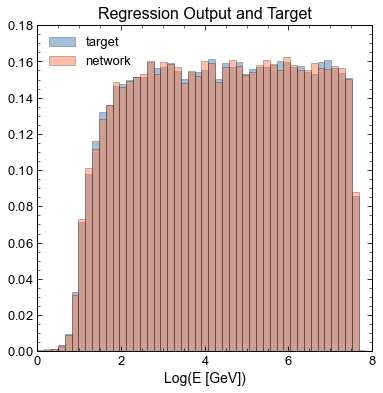

In [44]:
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.log(Y[:,0]), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(np.log(preds), color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [16]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution

<Figure size 799.992x599.976 with 0 Axes>

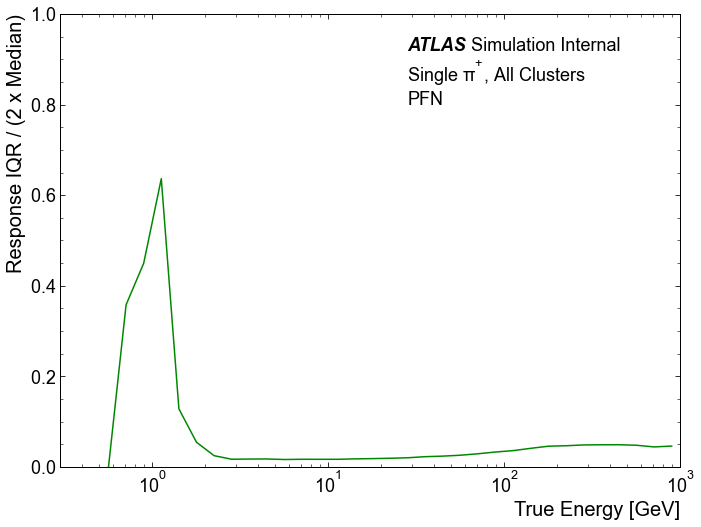

In [45]:
xcenter, PFN_5f = resolutionPlot(Y[:,0], preds/Y[:,0],
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])

<Figure size 799.992x599.976 with 0 Axes>

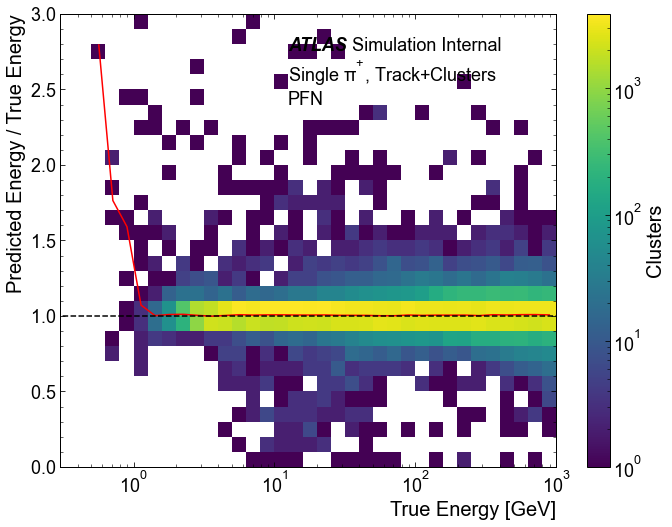

In [46]:
xcenter, med_PFN_5f = ru.responsePlot(Y[:,0], y=preds/Y[:,0],
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, Track+Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'PFN'}])

In [8]:
import tensorflow_probability as tfp

def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))

def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def ParticleFlow_MDN(num_features, name="PFN_MDN_Network"):
    
    event_shape = [1]
    num_components = 3
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)


    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.))(activation_5)

    
    mdn_0 = tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor)(dense_6)
    
    return keras.Model(inputs=inputs, outputs=mdn_0, name=name)

In [9]:
PFN_mdn = ParticleFlow_MDN(num_features=5)

In [10]:
PFN_mdn.summary()

Model: "PFN_MDN_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, None, 100)    0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, None, 100)    10100       activation_0[0][0]               
____________________________________________________________________________________

In [19]:
def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))

def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def ParticleFlow_MDN(num_features, num_components,name="PFN_MDN_Network"):
    
    event_shape = [1]
    num_components = num_components
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)


    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.))(activation_5)

    
    mdn_0 = tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor)(dense_6)
    
    return keras.Model(inputs=inputs, outputs=mdn_0, name=name)

In [20]:
PFN_mdn = ParticleFlow_MDN(num_features=5, num_components=3)

In [11]:
PFN_mdn.load_weights(ext_modelpath + 'PFN_MDN_regressor_weight_dg.h5')
preds = np.exp(PFN_mdn.predict(eval_generator(X,500)))
print(preds.shape)

(164784, 2)


In [12]:
preds

array([[ 13.321202 ,   1.0281578],
       [ 23.98733  ,   1.0300012],
       [290.09113  ,   1.0791346],
       ...,
       [505.06787  ,   1.0891358],
       [  4.461888 ,   1.025989 ],
       [123.792625 ,   1.0510831]], dtype=float32)

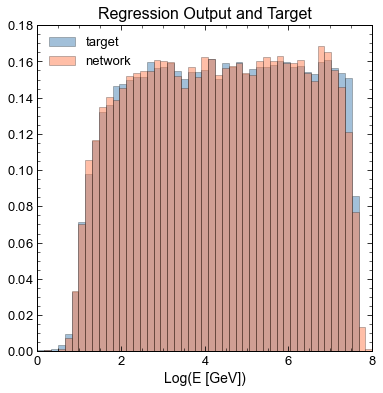

In [13]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.log(Y[:,0]), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(np.log(preds[:,0]), color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

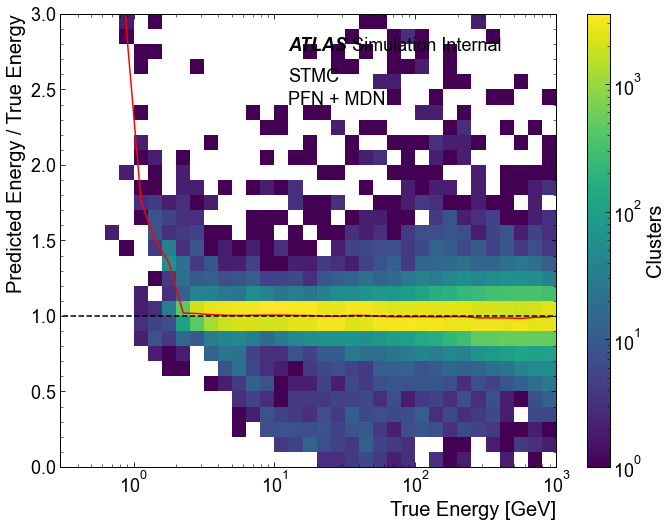

In [14]:
xcenter, medPFNMDN = ru.responsePlot(x=Y[:,0], y=preds[:,0]/Y[:,0],
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'STMC'},
                             {'x': 0.46, 'y': 0.8,  'text': 'PFN + MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

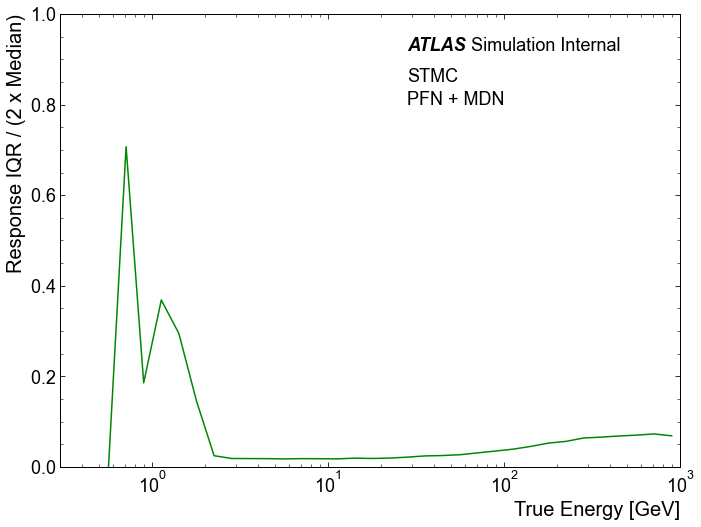

In [17]:
xcenter, iqrPFNMDN = resolutionPlot(x=Y[:,0], y=preds[:,0]/Y[:,0],
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'STMC'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

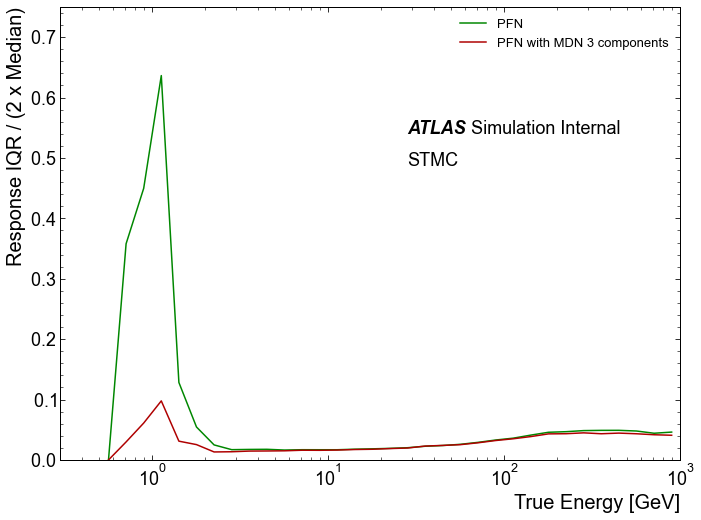

In [47]:
pu.lineOverlay(xcenter=xcenter, lines = [PFN_5f, iqrPFNMDN],
                labels = ['PFN', 'PFN with MDN 3 components'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'STMC'}])

In [18]:
median = preds[:,0]
sigma = np.log(preds[:,1])*median

# Calculate pull
pull = (median-Y[:,0]) / sigma
badval_mask = np.logical_and(pull < 6, pull > -6)
pull = pull[badval_mask]

In [54]:
sigma

array([ 0.50048107,  0.49571994, 15.268714  , ..., 56.963917  ,
        0.34260884,  4.570376  ], dtype=float32)

In [37]:
preds

array([[ 13.168809 ,   1.0387365],
       [ 21.444523 ,   1.0233856],
       [285.42825  ,   1.0549507],
       ...,
       [538.952    ,   1.1114815],
       [  4.4823627,   1.0794319],
       [123.61578  ,   1.0376644]], dtype=float32)

In [52]:
pull

array([-0.46002187, -0.95337817,  0.55090167, ...,  1.15206169,
       -0.23609372, -0.73531298])

<Figure size 799.992x599.976 with 0 Axes>

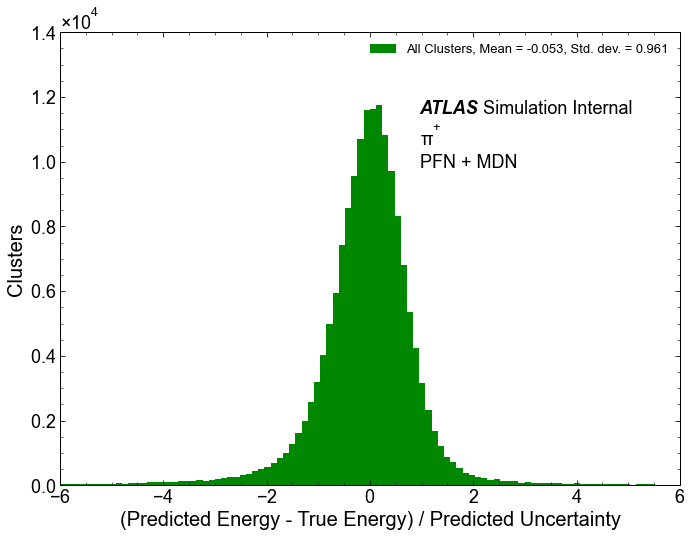

In [19]:
# Plot pull
n_bins = 100
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pull,bins = n_bins, label='All Clusters, Mean = {:.3f}, Std. dev. = {:.3f}'.format(pull.mean(), pull.std()))
plt.xlabel('(Predicted Energy - True Energy) / Predicted Uncertainty')
plt.ylabel('Clusters')
plt.xlim(-6,6)
plt.legend()

atlas_x = 0.58
atlas_y = 0.85
simulation = True
textlist = [{'x': 0.58, 'y': 0.75, 'text': '$\pi^{+}$'},
            {'x': 0.58, 'y': 0.7, 'text': 'PFN + MDN'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

In [64]:
median_over_true = median / Y[:,0]   #   Reconstructed Energy / True Energy
iqr_over_median = 2 * sigma / median  # Reconstructed Energy Resolution Per Cluster
iqr_over_true = 2 * sigma / Y[:,0]  # Pred Sigma / True Energy Per Cluster

<Figure size 799.992x599.976 with 0 Axes>

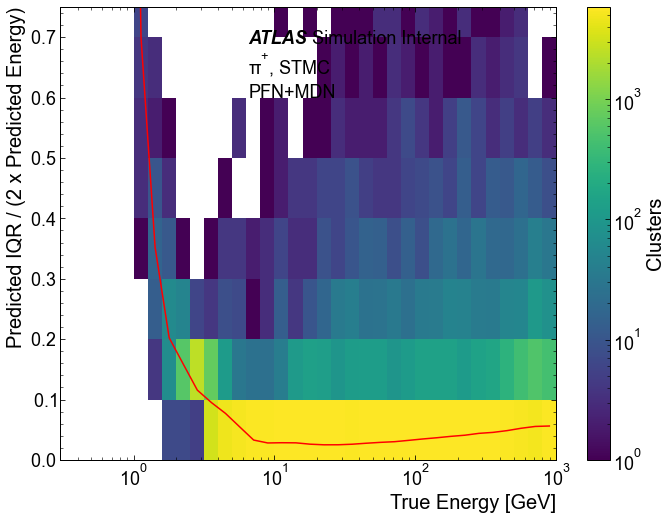

<Figure size 799.992x599.976 with 0 Axes>

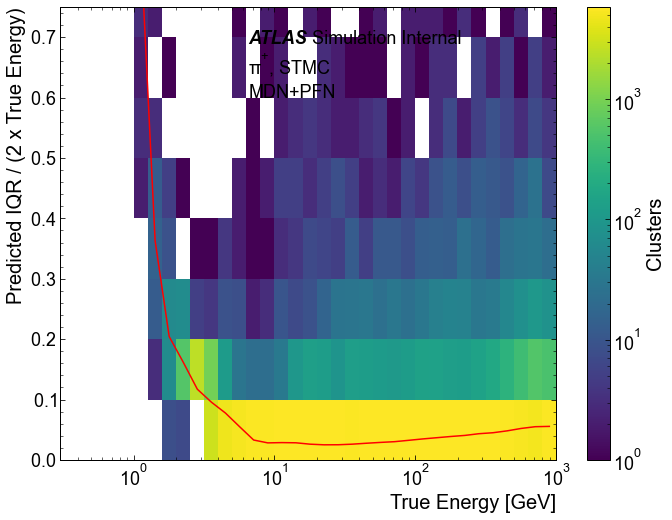

In [68]:
xcenter, iqrOverMed_MDN_learned = ru.responsePlot(Y[:,0], iqr_over_median/2,
                 'median', 
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,0.75), baseline=False,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': '$\pi^{+}$, STMC'},
                             {'x': 0.38, 'y': 0.8,  'text': 'PFN+MDN'}])

xcenter, iqrOverTrue_MDN_learned = ru.responsePlot(Y[:,0], iqr_over_true/2,
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,0.75), baseline=False,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x True Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': '$\pi^{+}$, STMC'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN+PFN'}])